In [55]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
plt.rcParams.update({'font.size': 22})

N_SAMPLE = 256 # Number of samples per waveform
N_CHANNEL = 30 # Number of channels per acdc board
N_BOARDS = 8 # Maximum number of acdc boards
SIGN = -1 # Setting for the expected sign of the pulse
THRESHOLD = 30 # Setting for the threshold to count a pulse as a pulse
WIDTH_NS = 5 # Pulse width in ns

# Function to load a set of events from one acdc board at a time
def load_board_data(filename, offset):
    # Loads 30 channels with an offset that is determined by the board number 
	raw_data = np.loadtxt(filename, delimiter=" ", usecols = range(0+offset,30+offset))
    # Return a matrix of data with the dimensions [N*256,30], 
    # where n is the number of available events in the file
	return raw_data

# Function to get the amount of read-out acdc boards from the amount 
# of available channels
def get_board_number(filename):
    # Read the first line of the file and split it on every ' '
    f = open(filename, "r").readline()
    # Then count the amount of entries
    connectedBoards = len(f.split())
    # Return the number of acd boards
    return connectedBoards

# Function to determine the pedestal of the current PSEC chip
def getPedestal(channel, meta_event):
    # Depending on the current channels corresponding PSEC chip
    # read the metadata coloumn to get the set pedestal value
    if ch>=0 and ch<=5:
        pedestal = int(meta_event[21],16)
    elif ch>=6 and ch<=11:
        pedestal = int(meta_event[22],16)
    elif ch>=12 and ch<=17:
        pedestal = int(meta_event[23],16)
    elif ch>=18 and ch<=23:
        pedestal = int(meta_event[24],16)
    elif ch>=24 and ch<=29:
        pedestal = int(meta_event[25],16)
    else:
        print("Pedestal error")
    # Return the pedestal value
    return pedestal

# Function to restructure the data of an acdc board given by the clockcycle 
# the trigger happend in 
def restructure(data, cycleBit):
    # The cycleBit is given by the metadata and determines which of the 8
    # 320 MHz clockcycles the trigger happend in 32 samples * this bit is 
    # then the actual first sample 
    cycleSample = 32 * cycleBit
    # Create an empty new array for the transformation
    new_vector = np.empty(256)
    # Loop over all available samples
    for i in range(0,N_SAMPLE):
        # Copy every sample from the actual first sample to the last sample in first
        # then switch around and start at 0 
        if i<(N_SAMPLE-cycleSample):
            new_vector[i] = data[i+cycleSample]
        else: 
            new_vector[i] = data[i-(N_SAMPLE-cycleSample)]
    # Retrun this new restructured array
    return new_vector

# Function to check the waveform for the sign of its pulse, if the sign matches the expected sign
# return true. If it does not match return false
def checkSign(data, pedestal):
    # Look for the global maximum and minimum in the samples of the waveform
    max_data = np.amax(data)
    min_data = np.amin(data)
    # Calculate the difference between the glomal extrema and the pedestal
    delta_max = abs(max_data-pedestal)
    delta_min = abs(min_data-pedestal)
    # Create an empty sign to be set
    sign = 0
    # Compare the threshold set to determine peaks with the gloabal extrema
    # Depending on the result choose a sign or thow an error
    if delta_max>THRESHOLD and delta_min>THRESHOLD:
        sign = 2
    elif delta_max>THRESHOLD and delta_min<THRESHOLD:
        sign = 1
    elif delta_max<THRESHOLD and delta_min>THRESHOLD:
        sign = -1
    # Catch the sign just being empty
    if sign==0:
        print("ERROR sign is " + str(sign))
    # Compare the calculated sign with the expected sign
    if sign==SIGN:
        return True
    else:
        return False

# Function to check if the pulse height is enough to be counted as a pulse
def checkHeight(data,pedestal):
    checkMark = False
    # Depending on the expected sign switch between minima and maxima search
    if SIGN==1:
        max_data = np.amax(data)
    elif SIGN==-1:
        max_data = np.amin(data)
    else:
        print("SIGN error") 
    # Calculate the difference between the glomal extrema and the pedestal
    delta = abs(max_data-pedestal)
    # If the difference between pedestal and max/min pulse height is enough
    # return either false or true
    if delta > THRESHOLD:
        checkMark = True
    return checkMark
    
# Function to check pulse length
def checkWidth(data, pedestal):
    checkMark = False   
    x = range(0,N_SAMPLE)
    i_r = 0
    i_l = 0
    # Depending on the expected sign switch between minima and maxima search
    if SIGN==1:
        max_data = np.amax(data)
    elif SIGN==-1:
        max_data = np.amin(data)
    else:
        print("SIGN error") 
    pos_max = np.argmax(data)
    for i in range(1,N_SAMPLE-pos_max):
        if abs(data[pos_max+i]-pedestal) < max_data-0.9*(max_data-pedestal) and i_r==0:
            i_r = i
        if abs(data[pos_max-i]-pedestal) < max_data-0.9*(max_data-pedestal) and i_l==0:  
            i_l = i
        if i_r!=0 and i_l!=0:
            break
    bins = 25/256
    width = (i_l+i_r)*bins
    
    if width/2 < WIDTH_NS/2+0.34*WIDTH_NS or width/2 > WIDTH_NS/2-0.34*WIDTH_NS:
        checkMark = True
    return checkMark

KeyboardInterrupt: 

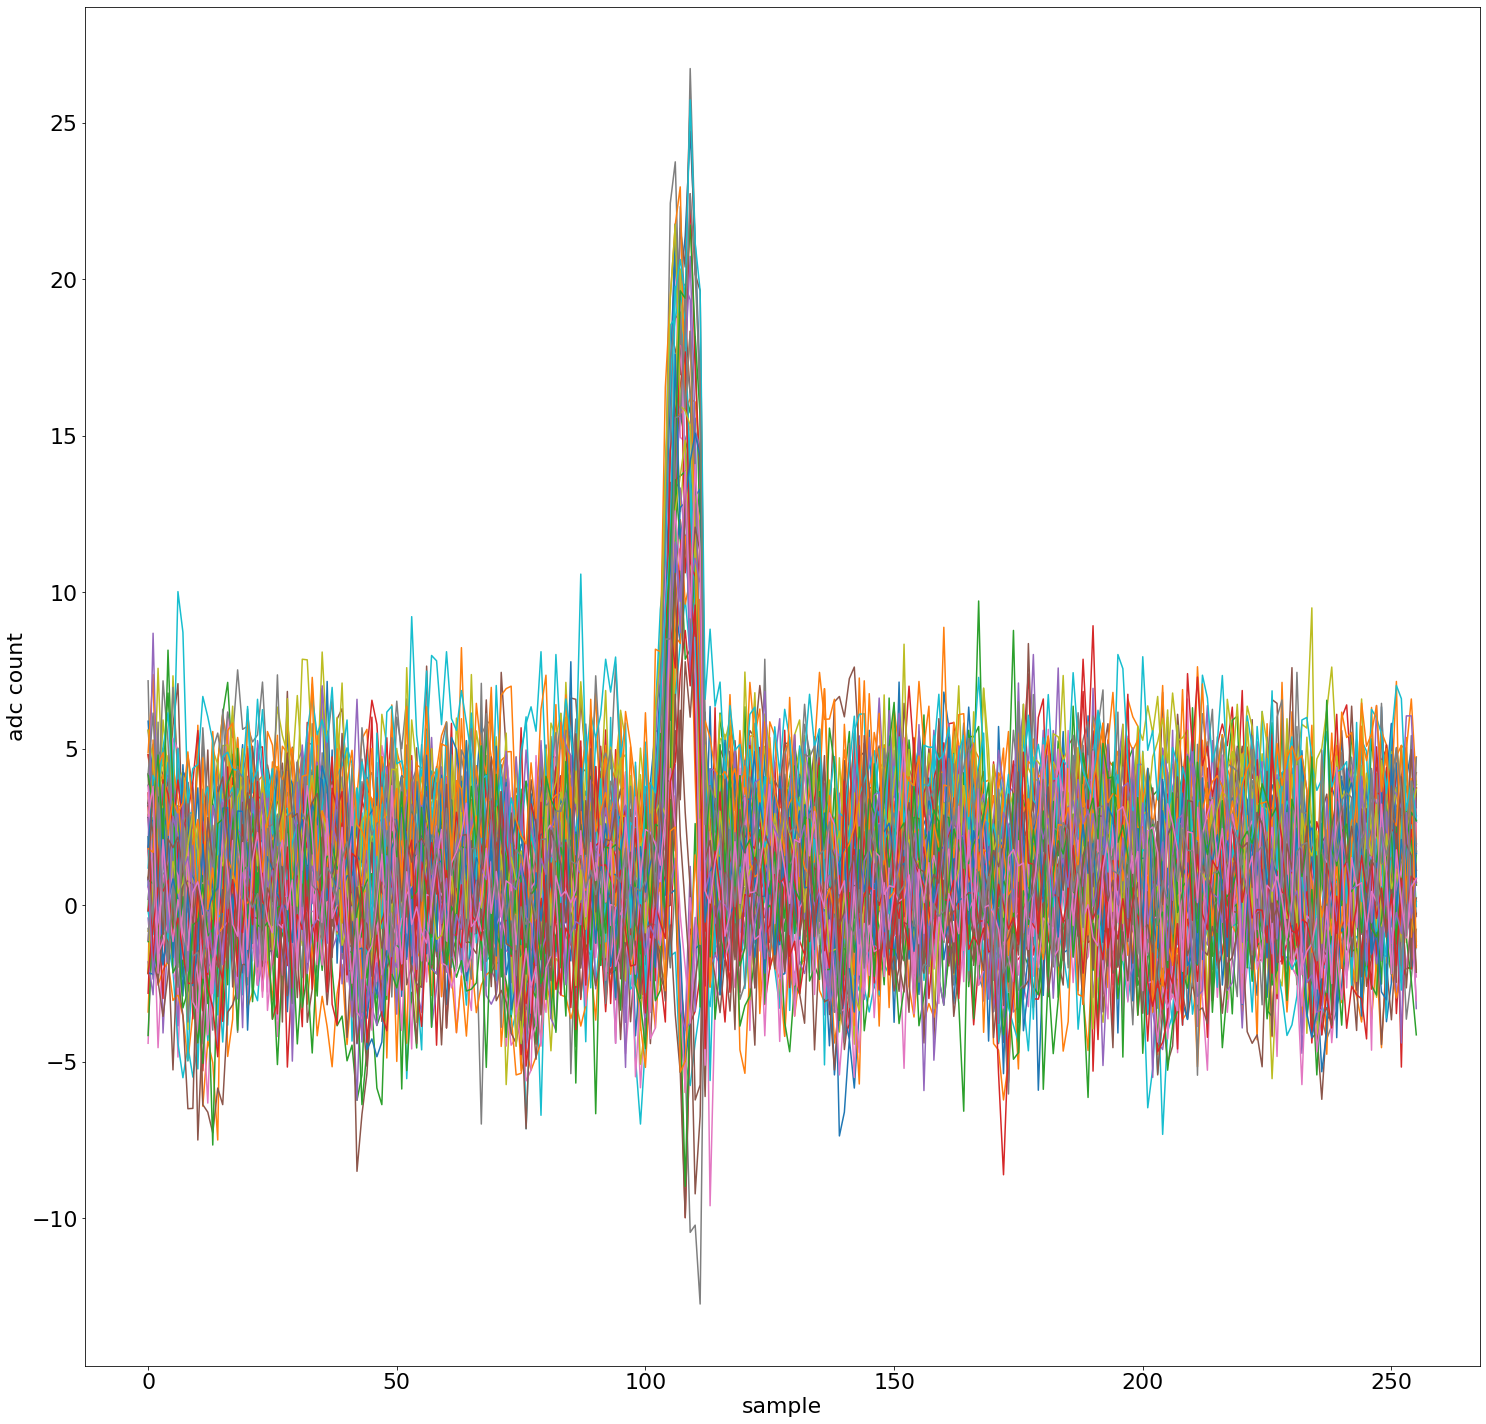

In [62]:
# Set the filename from an input argument
filename = "/home/pipc/Documents/Try2/Results/Data_20200812_110403.txt"
calibfile = "/home/pipc/Documents/Try2/PEDS_ACDC_board4.txt"
savefolder = "/home/pipc/Documents/Try2/"
calib = np.loadtxt(calibfile, delimiter=" ", usecols=range(0,30));
# Get the number of acdc boards that were read out
num_boards = (get_board_number(filename)-1)/31
# Create helper variables like a arbitrary x axis
# and counter for found pulses and processed channels
x = range(0,N_SAMPLE)
counter = 0
chk_counter = 0
# Loop ober all the read out acdc boards
for bi in range(0,int(num_boards)):
    # Grab the data of one acdc board and get the number of recorded events
    data = load_board_data(filename,bi*31+1)
    number_of_events = len(data[:,1])/N_SAMPLE
    # Create an empty final table
    count_table = np.empty(int(num_boards)*N_CHANNEL, dtype=int)
    # Grab the metadata of one acdc board
    meta = np.loadtxt(filename, dtype=np.str, delimiter=" ", usecols = (bi+1)*31)
    h = np.empty(int(number_of_events))
    # Loop over all channels
    for ch in range(0,N_CHANNEL):
        # Loop over all events
        chk_counter = 0
        for ev in range(0,int(number_of_events)):
            # Generate an event offset
            event = ev*N_SAMPLE
            # Grab only the respective metadata 
            meta_event = meta[0+event:256+event]
            # and extract the clockcycle bit
            bit = int(meta_event[26],16)
            # Grab only the respective data
            y = data[0+event:256+event,ch]
            # and restructure it with the clockcycle bit
            y = y - calib[:,ch]
            #y = restructure(y, bit)
            #y = calib[:,ch]
            # Catch events that are not complete
            if len(y)!=N_SAMPLE or len(meta_event)!=N_SAMPLE:
                print("len error")
                break
            # Get the pedestal value from the metadata
            pedestal = getPedestal(ch, meta_event)
            # Check the waveform for a pulse by checking on the 
            # correct sign as well as pulse height
####################################################################
            plt.figure(num=ch, figsize=[25,25], facecolor='white')
            plt.plot(x,y)
            plt.xlabel('sample')
            plt.ylabel('adc count')
            printname = savefolder + "Plot_"+ str(ch) + ".png"
            plt.savefig(printname)
            h[ev] = np.amax(y+calib[:,ch])
        # Every channel
        plt.close(ch)
        plt.figure(num=ch, figsize=[25,25], facecolor='white')
        plt.hist(h, bins=np.arange(min(h), max(h) + 1, 1))
        plt.xlabel('pulse height in adc')
        plt.ylabel('count')
        printname = savefolder + "Hist_" + str(ch) + ".png"
        plt.savefig(printname)
        # Every channel
        plt.close(ch)